## CS 476 A3 Q3
#### Jeongseop Yi (Patrick), j22yi

#### a)

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def butterflyPayoff(S, K1, K3):
    K2 = (K1 + K3) / 2
    if np.isnan(S):
        return np.nan
    if S > K1 and S < K2:
        return S - K1
    elif S > K2 and S < K3:
        return K3 - S
    else:
        return 0

def binomialDeltaButterfly(S0, K1, K3, r, sigma, T, N):
    stock_array = np.empty((N+1, N+1))
    stock_array.fill(np.nan)
    option_array = np.empty((N+1, N+1))
    option_array.fill(np.nan)
    delta_array = np.empty((N+1, N+1))
    delta_array.fill(np.nan)
    # the value u, d, and q
    u = np.exp(sigma*np.sqrt(T/N))
    d = np.exp(-sigma*np.sqrt(T/N))
    q = (np.exp(r*T/N) - d) / (u - d)
    
    # calculate the stock price at each node
    for j in range(0, N+1):
        for i in range(0, j+1):
            stock_array[j, i] = S0 * (u**i) * (d**(j-i))

    # calculate the option price at the last node
    for j in range(0, N+1):
        option_array[N, j] = butterflyPayoff(stock_array[N, j], K1, K3)

    # loop through the binomial lattice backwards
    for i in range(N, 0, -1):
        # get lagged option array for calculation
        option_array_r = np.roll(option_array[i, :], -1).copy()
        # set the last value to nan
        option_array_r[-1] = np.nan
        # calculate the new option array
        option_array[i-1, :] = (np.exp(-r * T / N) * 
                                ((q * option_array_r) + ((1-q) * option_array[i, :])))
        
        # calculate the delta array
        delta_array[i-1, :] = (option_array_r - option_array[i, :]) \
            / ((u-d) * stock_array[i-1, :])

    return (option_array, delta_array, stock_array)

The code is very similar to the binomial lattice code we did in A2, but there are some notable differences.

1. The return values is a tuple of matrices for option, delta, and stock values with size of (n+1, n+1). All the values of the binomial lattice is in the return tuple.
2. delta is calculated with the option values while going backwards of the binomial lattice. $\delta^i_k = \frac{V^{i+1}_{k+1} - V^{i+1}_{k}}{(u-d) * S^{i}_k}$

#### b)

In [3]:
def interpDelta(delta, Sn, S):
    return np.interp(S, Sn, delta)

Numpy function `interp` is an interpolation function for python and does handle the reset of the interpolation value if the value S is outside of the range of Sn. 

#### c)

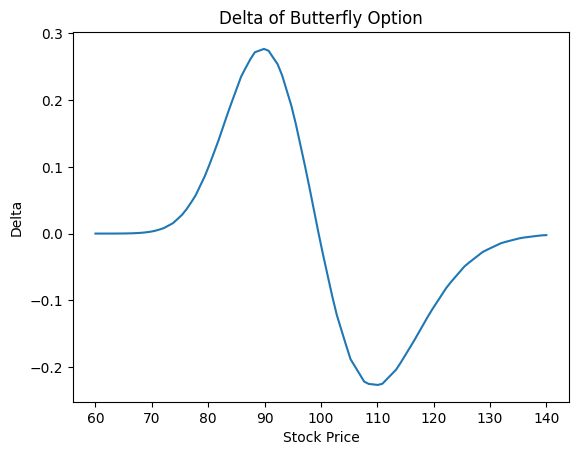

In [4]:
# Table 1 values
S0 = 100
K1 = S0 * 0.9
K3 = S0 * 1.1
r = 0.03
sigma = 0.2
N = 250
T = 1

# Calculations
S_lin = np.linspace(0.6 * S0, 1.4 * S0, 100)
V, delta, S = binomialDeltaButterfly(S0, K1, K3, r, sigma, T, N)
delta_interp = interpDelta(delta[int(0.8*N), :], S[int(0.8*N), :], S_lin)
plt.plot(S_lin, delta_interp)
plt.title("Delta of Butterfly Option")
plt.xlabel("Stock Price")
plt.ylabel("Delta")
plt.show()

The delta, option, and stock value matrices for the parameters in Table 1 is retrieved by `binomialDeltaButterfly`. 
The delta, stock values for $t_n, n = 0.8N$ were retrived using indexing from the matrices.
A graph of delta is plotted for $S=\text{linspace}(0.6S_0, 1.4S_0, 100)$ using `interpDelta`.

#### d)

In [5]:
def MC_simulation(S0, mu, sigma, T, M, N):
    Dt = T / N
    S = np.zeros((N+1, M))
    S[0, :] = S0
    for i in range(1, N + 1):
        S[i, :] = S[i-1, :] * \
                  np.exp((mu - sigma ** 2 / 2)
                         * Dt + sigma*np.sqrt(Dt)*np.random.normal(0, 1, M))
    return S

In [6]:
# Table 1 values
S0 = 100
K1 = S0 * 0.9
K3 = S0 * 1.1
r = 0.03
sigma = 0.2
N = 250
T = 1

M = 10000

# MC simulation and binomial lattice values
S_MC = MC_simulation(S0, r, sigma, T, M, N)
V, delta, S = binomialDeltaButterfly(S0, K1, K3, r, sigma, T, N)
V0 = V[0, 0]
VN = list(map(lambda x: butterflyPayoff(x, K1, K3), S_MC[N]))
B0 = V0 - S0 * delta[0, 0]

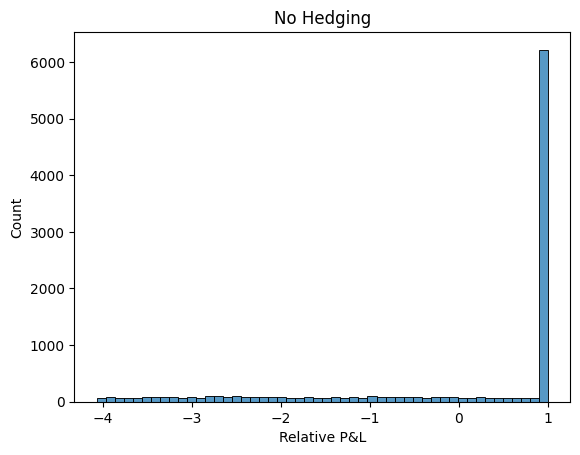

In [7]:
# calculate the daily, weekly, monthly and no hedging P&L
# No hedging
B0_no = V0 * np.ones(M) * np.exp(r * T)
PNL_no = (B0_no - VN)

PNL_N_relative = np.exp(-r*T) * PNL_no / V0
sns.histplot(PNL_N_relative, bins=50)
plt.title('No Hedging')
plt.xlabel('Relative P&L')
plt.show()


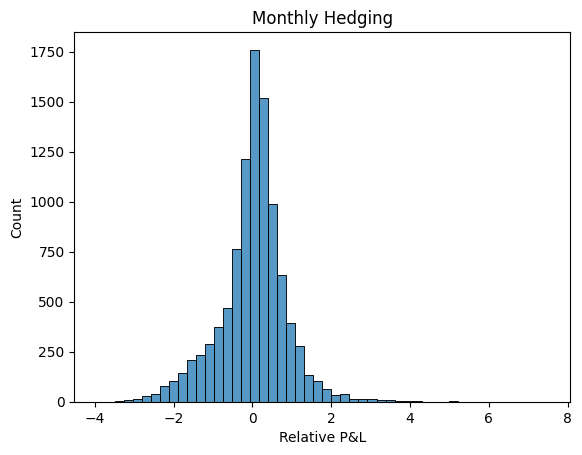

In [8]:
# Monthly hedging
B0_monthly = B0 * np.ones(M)
step = 20
for n in np.arange(step, N, step):
    Sn = S_MC[n-step]
    Sn1 = S_MC[n]
    dn = interpDelta(np.nan_to_num(delta[n-step]), np.nan_to_num(S[n-step], nan=np.inf), Sn) 
    dn1 = interpDelta(np.nan_to_num(delta[n]), np.nan_to_num(S[n], nan=np.inf), Sn1)

    B0_monthly = B0_monthly * np.exp(r * T / N * step) + (dn - dn1) * Sn1

laststep = np.arange(step, N, step)[-1]
PNL_monthly = (B0_monthly * np.exp(r * T / N * (N - laststep)) + 
               S_MC[N]*interpDelta(delta[laststep], S[laststep], S_MC[laststep]) - VN)

PNL_M_relative = np.exp(-r*T) * PNL_monthly / V0
sns.histplot(PNL_M_relative, bins=50)
plt.title('Monthly Hedging')
plt.xlabel('Relative P&L')
plt.show()

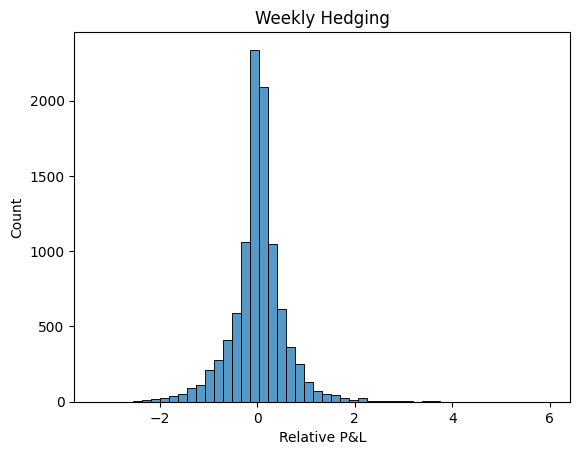

In [9]:
# Weekly hedging
B0_weekly = B0 * np.ones(M)
step = 5
for n in np.arange(step, N, step):
    Sn = S_MC[n-step]
    Sn1 = S_MC[n]
    dn = interpDelta(np.nan_to_num(delta[n-step]), np.nan_to_num(S[n-step], nan=np.inf), Sn)
    dn1 = interpDelta(np.nan_to_num(delta[n]), np.nan_to_num(S[n], nan=np.inf), Sn1)

    B0_weekly = B0_weekly * np.exp(r * T / N * step) + (dn - dn1) * Sn1

PNL_weekly = (B0_weekly * np.exp(r * T / N * step) + 
              S_MC[N]*interpDelta(delta[N-step], S[N-step], S_MC[N-step]) - VN)

PNL_W_relative = np.exp(-r*T) * PNL_weekly / V0
sns.histplot(PNL_W_relative, bins=50)
plt.title('Weekly Hedging')
plt.xlabel('Relative P&L')
plt.show()

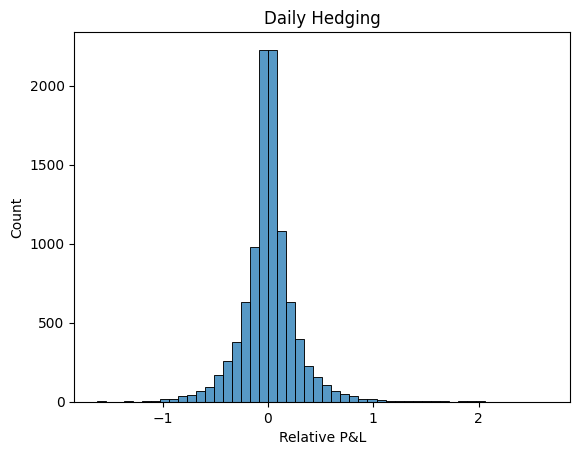

In [10]:
# Daily hedging
B0_daily = B0 * np.ones(M)
step = 1
for n in np.arange(step, N, step):
    Sn = S_MC[n-step]
    Sn1 = S_MC[n]
    dn = interpDelta(np.nan_to_num(delta[n-step]), np.nan_to_num(S[n-step], nan=np.inf), Sn)
    dn1 = interpDelta(np.nan_to_num(delta[n]), np.nan_to_num(S[n], nan=np.inf), Sn1)

    B0_daily = B0_daily * np.exp(r * T / N * step) + (dn - dn1) * Sn1

PNL_daily = (B0_daily * np.exp(r * T / N * step) + 
             S_MC[N]*interpDelta(delta[N-step], S[N-step], S_MC[N-step]) - VN)
PNL_D_relative = np.exp(-r*T) * PNL_daily / V0
sns.histplot(PNL_D_relative, bins=50)
plt.title('Daily Hedging')
plt.xlabel('Relative P&L')
plt.show()

M = 10000 is used to simulate the stock prices with the given underlying stock price.

Histogram for the no hedging relative P&L is concentrated to 1. This is expected as we do not hedge and keeps the first $B_0$ which is $V_0$. $V_N$ values are highly likely to be 0 when the $S_N$ outside of $K_1$ or $K_3$. 

All of the hedging histograms for relative P&L are centered at 0. However, the kurtosis of the histogram increases as the hedging frequency increases. 

This indicates that as the hedging frequency increases, the efficiency of the hedging increases. 

#### e)

In [11]:
def dVarCVar(PNL, beta):
    PNL = np.sort(PNL)
    N = len(PNL)
    dVar = PNL[int((1-beta)*N)]
    cVar = np.mean(PNL[PNL < dVar])
    return (dVar, cVar)

The function `dVarCVar` returns a tuple with $VaR$ and $CVaR$ value given the P&L array and the beta.

The function sorts the P&L array in ascending order and takes the closest bottom (1-beta) value from the array for $VaR$.

$CVaR$ is calculated by calculating the mean values of P&L values which is less than $VaR$. 

In [13]:
dVar_no, CVar_no = dVarCVar(PNL_no, 0.95)
dVar_daily, CVar_daily = dVarCVar(PNL_daily, 0.95)
dVar_weekly, CVar_weekly = dVarCVar(PNL_weekly, 0.95)
dVar_monthly, CVar_monthly = dVarCVar(PNL_monthly, 0.95)

dVarCVar_table = pd.DataFrame(columns=['No hedging', 'Monthly', 'Weekly', 'Daily'])
dVarCVar_table.loc['dVaR'] = [dVar_no, dVar_monthly, dVar_weekly, dVar_daily]
dVarCVar_table.loc['CVaR'] = [CVar_no, CVar_monthly, CVar_weekly, CVar_daily]
display(dVarCVar_table)

,No hedging,Monthly,Weekly,Daily
dVaR,-6.709519,-3.117423,-1.842707,-0.805091
CVaR,-7.336033,-4.058741,-2.640159,-1.194431


As the hedging frequency increases, the $VaR$ and $CVaR$ values for the hedging portfolio increases. This indicates that the effciency of the hedging portfolio increases as the frequency increases, and it is less likely for the writer to lose money and less money when such a event occurs. 

#### f)

A binomial lattice corresponding to time $t_b^{rb}$ can be created using interpolation of the options prices where $t_k < t_b^{rb} < t_{k+1}$ and $k$ is integer in the code to implement the hedging analysis. 